# **Reinforcement Learning Method to Optimise Traffic Light Signal Control in Typical Urban Four-Way Intersection Using SUMO Traffic Simulator**

Authors: 
- Alex Wang (z5420393)
- Dhwanish Kshatryia (z5421168)
- Evan Xiong (z5421149)
- Michael Wang (z5421148)
- Rohan Agarwal (z5423480)


In [68]:
import os
import sys
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import traci
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns


# **Introduction, Motivation and/or Problem Statement**

**Problem Statement**

Inefficient traffic light control results in increased levels of congestion. Higher levels of congestion will have detrimental impacts on society, as drivers will have more idle time which leads to the following issues:
- Poorer quality of life/Driver frustration due to being stuck in traffic
- Longer travel time due to delays in traffic
- Reduced economic productivity
- Higher levels of greenhouse emissions as vehicles will be on the road longer

Currently, Sydney adopts mostly fixed timers to control traffic lights. A traffic light control system based on fixed timers has caused delays in traffic such that it takes on average 15 more minutes to reach the same destination. Additionally, there's 6.1 billion in lost productivity annually. This issue is becoming increasingly relevant as Sydney's population is projected tor is and be 6.4 million by 2036. This means there will be more drivers on the road, which will contribute to higher levels of congestion.

Our objective is to optimise Sydney's traffic flow and reduce congestion by developing a traffic light control system that is efficient under most scenarios.

**Purpose**

To address this issue, we considered a reinforcement learning approach. As opposed to other approaches, reinforcement learning is able to handle sequential data through associating actions and delayed rewards. Optimising traffic flow has its applications in other fields, namely factoring queuing systems and warehouse automation.

# **RL Simulation Tool**

**Sumo Config**

In [69]:
def sumo_config(traffic_pattern="P1", seed=23423):
    sumo_config = [
        "sumo",
        "-c", f"SUMO_networks/{traffic_pattern}/junction.sumocfg",
        "--step-length", "0.05",
        "--delay", "0",
        "--lateral-resolution", "0.1",
        "--waiting-time-memory", "1800",
        "--seed", f"{seed}",
        "--start",
        "--no-warnings",
        "--no-step-log",
    ]
    return sumo_config

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Declare SUMO_HOME env variable")

if not traci.isLoaded():
    traci.start(sumo_config())


In [70]:
traffic_patterns = itertools.cycle(["P1", "P2", "P3", "P4"])

def reset_env(pattern="P1"):
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern, random.randint(1, 99999)))

def change_env():
    pattern = next(traffic_patterns)
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern, random.randint(1, 99999)))


describe SUMO

# **RL data design** (prob rename)

In [71]:
# Global Variables for Simulation
action_space_size = 8
TRAFFIC_LIGHT_ID = "traffic_light"
DELTA_PHASE_DURATION = 6 
YELLOW_PHASE_DURATION = 4 
lane_detectors = [f'q{i+1}' for i in range(8)]
current_phase = 2

# Returns the queue length for each lane detector
def get_queue_length():
    return torch.tensor([
        traci.lanearea.getLastStepHaltingNumber(d) for d in lane_detectors
    ], dtype=torch.float)

# Simulate 20 seconds
def simulate_time(seconds=1):
    for _ in range(20 * seconds):
        traci.simulationStep()


talk about traffic patterns, itnersection, 

# **Methods**

## **Baseline Model: Mimicing TrafficLightsNSW**

Description of baseline (code wil alctualyl run inside results section)

## **Q-Network Architecture**

In [72]:
def choose_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_space_size - 1)
    else:
        return torch.argmax(policy_net(state.unsqueeze(0))).item()


In [73]:
def optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states = torch.stack([x[0] for x in batch])
    actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
    rewards = torch.tensor([x[2] for x in batch], dtype=torch.float)
    next_states = torch.stack([x[3] for x in batch])
    dones = torch.tensor([x[4] for x in batch], dtype=torch.float)

    q_vals = policy_net(states).gather(1, actions).squeeze()
    with torch.no_grad():
        max_next_q_vals = target_net(next_states).max(1)[0]
        target_vals = rewards + gamma * max_next_q_vals * (1 - dones)
    loss = nn.MSELoss()(q_vals, target_vals)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## **Architecture 1: Fully Connected Q-Network**

In [74]:
class DQN_FC(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.main(x)


In [75]:
# The current state is defined as queue length for each lane detector
def get_current_state():
    return get_queue_length()


In [76]:
def step(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
        
    next_state = get_current_state()
    reward = -torch.sum(next_state)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, next_state.clone() 


## **Architecture 2: CNN Q-Network**

In [77]:
class DQN_CNN(nn.Module):
    def __init__(self, num_actions):
        super(DQN_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv3(x))   
        
        x = x.view(x.size(0), -1)   
        x = F.relu(self.fc1(x))
        return self.output(x)      


In [78]:
def generate_occupancy_grid(grid_size=(84, 84),
                             bounds=(-115, 100, -90, 125)):
    x_min, x_max, y_min, y_max = bounds
    x_scale = grid_size[1] / (x_max - x_min)
    y_scale = grid_size[0] / (y_max - y_min)

    grid = torch.zeros(grid_size, dtype=torch.float32)

    for v_id in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(v_id)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = int((x - x_min) * x_scale)
            row = int((y - y_min) * y_scale)

            if 0 <= row < grid_size[0] and 0 <= col < grid_size[1]:
                grid[row, col] = 1.0  

    return grid

frame_buffer = deque(maxlen=4)

def get_current_state_cnn():
    frame_buffer.clear()  # clear previous frames to maintain consistency

    for _ in range(4):
        simulate_time(1)  # simulate 1 second
        grid = generate_occupancy_grid()
        frame_buffer.append(grid.unsqueeze(0))

    state = torch.cat(list(frame_buffer), dim=0)
    return state


def step_cnn(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    next_state = get_current_state_cnn()
    queue_length = get_queue_length()
    reward = -torch.sum(queue_length)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, queue_length


## **Hyperparameter Tuning Results**

import the grid search csvs and show

In [79]:
fc_optimal_params = {
    "gamma": 0.99,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}


In [80]:
cnn_optimal_params = {
    "gamma": 0.999,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}


## **Training**

In [ ]:
# Add per-lane metrics
def train_fc_agent(params, episodes=200):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    state_dim = len(lane_detectors)
    policy_net = DQN_FC(state_dim, action_space_size)
    target_net = DQN_FC(state_dim, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    steps_done = 0

    pattern_names = ["P1", "P2", "P3"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)

    for episode in range(episodes):
        change_env()
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        state = get_current_state()
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        # Aggregate queue stats
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards[current_pattern].append(episode_reward.item())
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

    N = max(1, int(0.2 * episodes))  # 20% of episodes
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [ ]:
fc_results = train_fc_agent(fc_optimal_params, episodes=200)


In [ ]:
policy_fc = fc_results["trained_model"]
model_path = f"policy_fc_nn.pt"
torch.save(policy_fc.state_dict(), model_path)


In [ ]:
# Add per-lane metrics
def train_cnn_agent(params, episodes=200):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    policy_net = DQN_CNN(action_space_size)
    target_net = DQN_CNN(action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    steps_done = 0

    pattern_names = ["P1", "P2", "P3"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)

    for episode in range(episodes):
        change_env()
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        state = get_current_state_cnn()
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step_cnn(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards[current_pattern].append(episode_reward.item())
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

    N = max(1, int(0.2 * episodes))
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [ ]:
cnn_results = train_cnn_agent(cnn_optimal_params, episodes=200)


In [ ]:
policy_cnn = cnn_results["trained_model"]
model_path = f"policy_cnn_nn.pt"
torch.save(policy_cnn.state_dict(), model_path)


# **Results**

In [41]:
sns.set(style="whitegrid", context="notebook", palette="deep")

def plot_line(rewards, label, ylabel, title, baselines=None):
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette("deep")
    main_color = palette[0]

    plt.plot(rewards, label=label, linewidth=2.5, marker='o', markersize=4,
             alpha=0.9, color=main_color)

    if baselines is not None:
        labels = ["P1: Major/minor road", "P2: Through/left-turn lane ", "P3: Tidal traffic"]
        for i, val in enumerate(baselines):
            if val is not None:
                color = palette[i + 1] if i + 1 < len(palette) else 'gray'
                label_text = labels[i] if i < len(labels) else f"P{i+1}"
                plt.axhline(y=val, color=color, linestyle='--', linewidth=2,
                            alpha=0.8, label=label_text)

    plt.xlabel("Episode", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, weight='bold')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


## **Baseline Results**

In [ ]:

def get_baseline_results(pattern, episodes=1):

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    phase_sequence = [2, 6, 4, 0]
    green_duration = DELTA_PHASE_DURATION
    yellow_duration = YELLOW_PHASE_DURATION

    for episode in range(episodes):
        reset_env(pattern)

        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        phase_index = 0

        while not done:
            green_phase = phase_sequence[phase_index]
            yellow_phase = green_phase + 1

            # Green
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, green_phase)
            simulate_time(green_duration)
            num_steps += 1

            # Reward
            next_state = get_current_state()
            reward = -torch.sum(next_state)
            done = traci.simulation.getMinExpectedNumber() == 0
            curr_queue = next_state.clone()

            episode_reward += reward

            # Wait tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]


            # Yellow
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, yellow_phase)
            simulate_time(yellow_duration)

            phase_index = (phase_index + 1) % len(phase_sequence)

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [86]:
baseline_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    baseline_results = get_baseline_results(pattern, episodes=100)
    rewards = baseline_results["pattern_rewards"]
    avg_waits = baseline_results["pattern_avg_waits"]
    max_waits = baseline_results["pattern_max_waits"]

    for r in rewards:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")



Pattern P1:
 Episodes: 100
 Avg Reward: -2901.72
 Avg Wait: 26.42
 Max Wait: 219.55

Pattern P2:
 Episodes: 100
 Avg Reward: -6904.53
 Avg Wait: 60.70
 Max Wait: 471.20

Pattern P3:
 Episodes: 100
 Avg Reward: -6131.47
 Avg Wait: 47.68
 Max Wait: 379.95

Pattern P4:
 Episodes: 100
 Avg Reward: -1838.72
 Avg Wait: 20.61
 Max Wait: 139.20


## **Model 1 results**

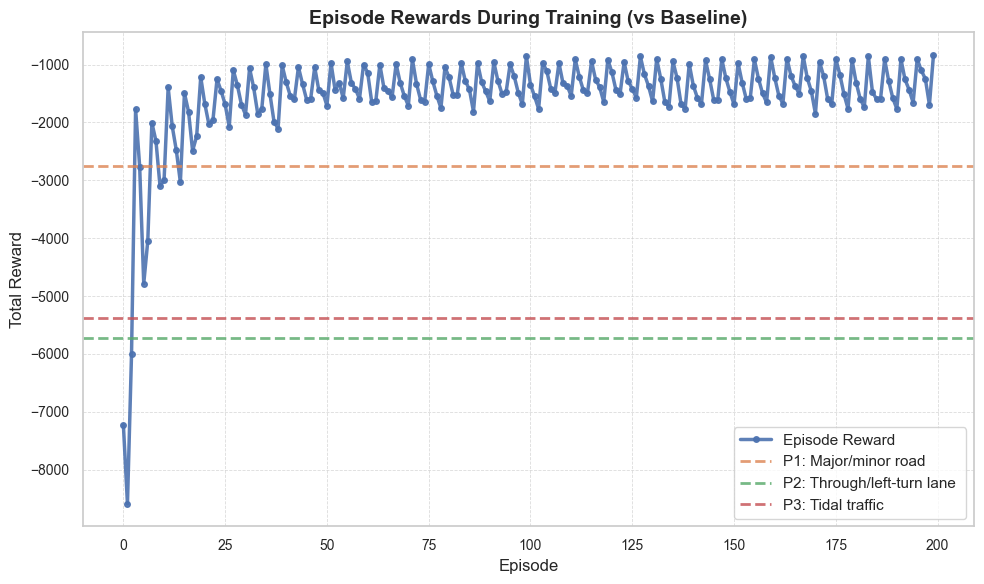

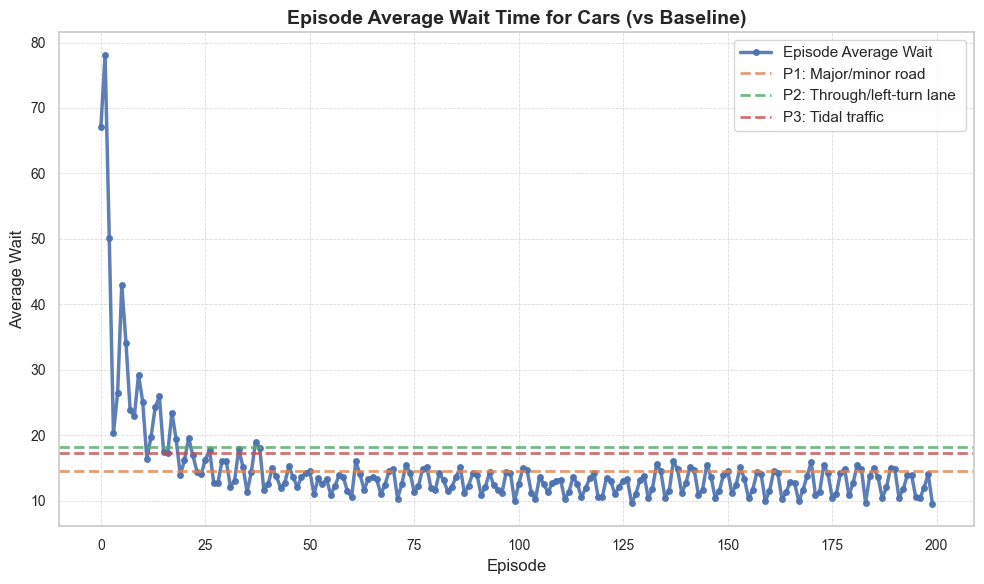

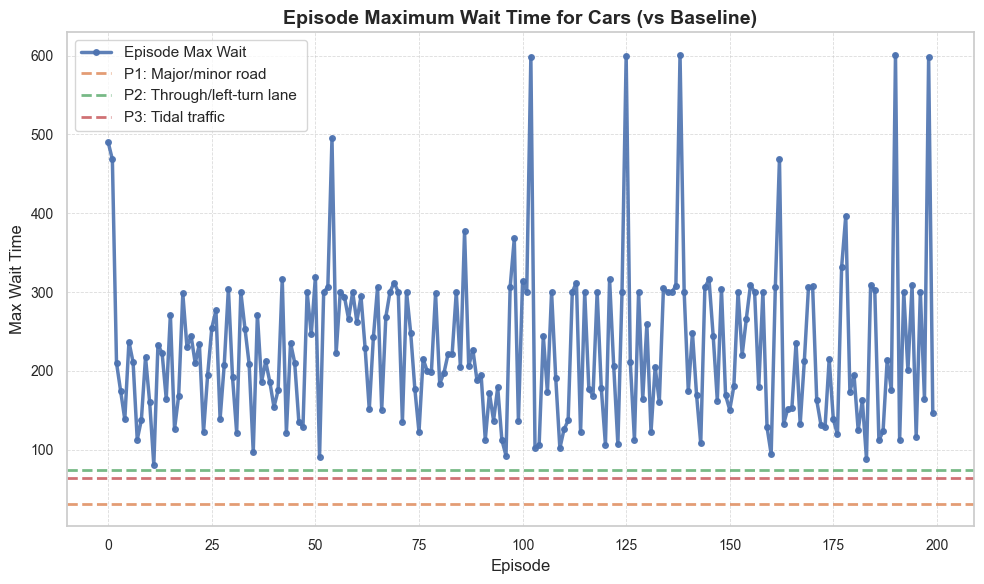

In [15]:
plot_line(fc_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2758, -5730, -5383])
plot_line(fc_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [14.57, 18.23, 17.33])
plot_line(fc_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [31.25, 73.55, 64.05])


In [16]:
print("### Fully Connected Q-Network Results ###")
for pattern in ["P1", "P2", "P3"]:
    rewards = fc_results["pattern_rewards"][pattern]
    avg_waits = fc_results["pattern_avg_waits"][pattern]
    max_waits = fc_results["pattern_max_waits"][pattern]
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")
print(f"\nAverage Reward (Last 40): {fc_results['avg_reward_last_N']:.2f}")
print(f"Average Wait (Last 40): {fc_results['avg_wait_last_N']:.2f}")
print(f"Max Wait (Last 40): {fc_results['max_wait_last_N']:.2f}")


### Fully Connected Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1547.51
 Avg Wait: 14.71
 Max Wait: 601.10

Pattern P2:
 Episodes: 67
 Avg Reward: -1546.70
 Avg Wait: 14.75
 Max Wait: 601.10

Pattern P3:
 Episodes: 66
 Avg Reward: -1552.21
 Avg Wait: 14.65
 Max Wait: 599.60

Average Reward (Last 40): -1330.55
Average Wait (Last 40): 12.62
Max Wait (Last 40): 601.10


In [ ]:
def evaluate_fc_model_on_pattern(pattern, model_path=f"policy_fc_nn.pt", episodes=1):
    policy_net = DQN_FC(len(lane_detectors), action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state()

        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
                
            next_state, reward, done, curr_queue = step(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [49]:
fc_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    fc_results = evaluate_fc_model_on_pattern(pattern, episodes=100)
    rewards = fc_results["pattern_rewards"]
    avg_waits = fc_results["pattern_avg_waits"]
    max_waits = fc_results["pattern_max_waits"]

    for r in rewards:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


C:\Users\alexw\AppData\Local\Temp\ipykernel_38348\2286365116.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path))
C:\Users\


Pattern P1:
 Episodes: 100
 Avg Reward: -1311.67
 Avg Wait: 12.10
 Max Wait: 922.00

Pattern P2:
 Episodes: 100
 Avg Reward: -1641.54
 Avg Wait: 15.09
 Max Wait: 1481.35

Pattern P3:
 Episodes: 100
 Avg Reward: -1655.37
 Avg Wait: 13.76
 Max Wait: 1478.40

Pattern P4:
 Episodes: 100
 Avg Reward: -919.46
 Avg Wait: 10.18
 Max Wait: 869.15


## **Model 2 results**

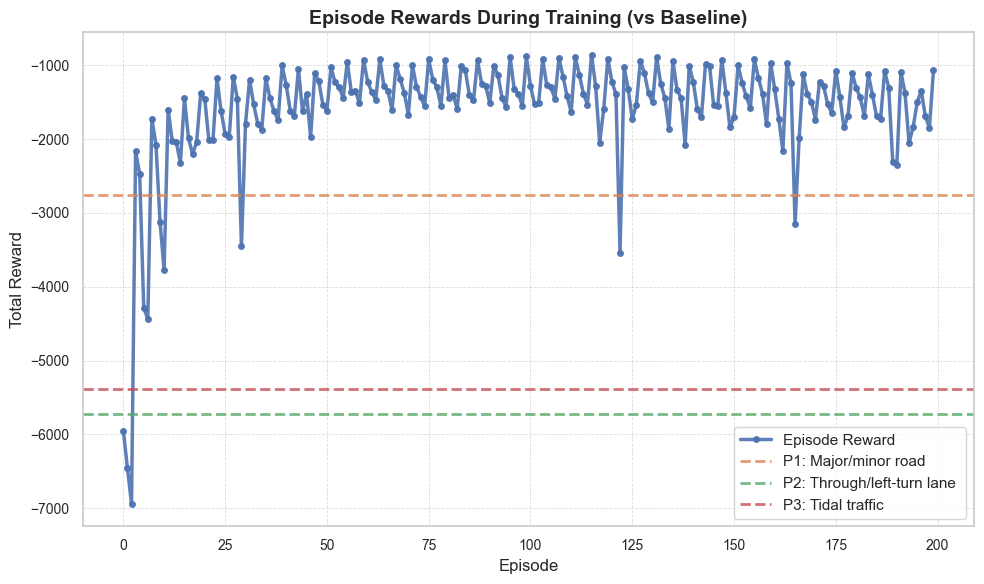

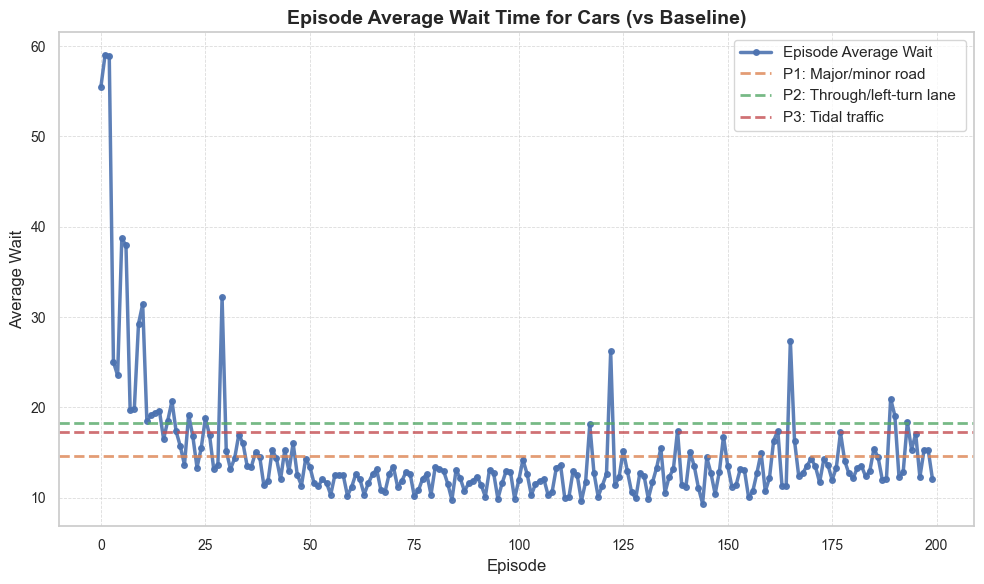

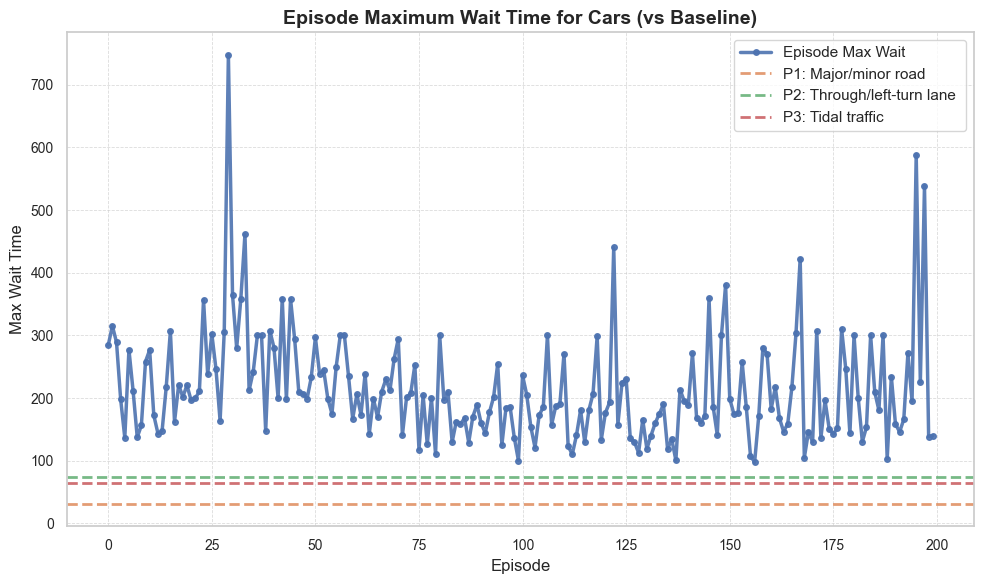

In [29]:
plot_line(cnn_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2758, -5730, -5383])
plot_line(cnn_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [14.57, 18.23, 17.33])
plot_line(cnn_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [31.25, 73.55, 64.05])


In [28]:
print("\n### CNN Q-Network Results ###")

for pattern in ["P1", "P2", "P3"]:
    rewards = cnn_results["pattern_rewards"][pattern]
    avg_waits = cnn_results["pattern_avg_waits"][pattern]
    max_waits = cnn_results["pattern_max_waits"][pattern]

    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")
print(f"\nAverage Reward: {cnn_results['avg_reward']:.2f}")
print(f"Average Reward (Last 40): {cnn_results['avg_reward_last_N']:.2f}")
print(f"Average Wait (Last 40): {cnn_results['avg_wait_last_N']:.2f}")
print(f"Max Wait (Last 40): {cnn_results['max_wait_last_N']:.2f}")



### CNN Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1594.52
 Avg Wait: 14.88
 Max Wait: 588.60

Pattern P2:
 Episodes: 67
 Avg Reward: -1540.61
 Avg Wait: 14.34
 Max Wait: 359.20

Pattern P3:
 Episodes: 66
 Avg Reward: -1611.50
 Avg Wait: 14.86
 Max Wait: 747.90

Average Reward: -1582.07
Average Reward (Last 40): -1558.28
Average Wait (Last 40): 14.42
Max Wait (Last 40): 588.60


In [ ]:
def evaluate_cnn_model_on_pattern(pattern, model_path=f"policy_cnn_nn.pt", episodes=1):
    policy_net = DQN_CNN(action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state_cnn()

        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
                
            next_state, reward, done, curr_queue = step_cnn(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [58]:
cnn_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    cnn_results = evaluate_cnn_model_on_pattern(pattern, episodes=100)
    rewards = cnn_results["pattern_rewards"]
    avg_waits = cnn_results["pattern_avg_waits"]
    max_waits = cnn_results["pattern_max_waits"]

    for r in rewards:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


C:\Users\alexw\AppData\Local\Temp\ipykernel_38348\159283917.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path))
C:\Users\a


Pattern P1:
 Episodes: 100
 Avg Reward: -1411.14
 Avg Wait: 12.95
 Max Wait: 891.45

Pattern P2:
 Episodes: 100
 Avg Reward: -1734.91
 Avg Wait: 15.72
 Max Wait: 877.70

Pattern P3:
 Episodes: 100
 Avg Reward: -2994.02
 Avg Wait: 20.07
 Max Wait: 1773.75

Pattern P4:
 Episodes: 100
 Avg Reward: -997.74
 Avg Wait: 11.03
 Max Wait: 861.50


## **Comparisons**

In [ ]:
cnn_results_compiled = pd.read_csv("cnn_results_compiled.csv")
fc_results_compiled = pd.read_csv("fc_results_compiled.csv")
baseline_results_compiled = pd.read_csv("baseline_results_compiled.csv")

cnn_results_compiled["Model"] = "CNN"
fc_results_compiled["Model"] = "FC"
baseline_results_compiled["Model"] = "Baseline"


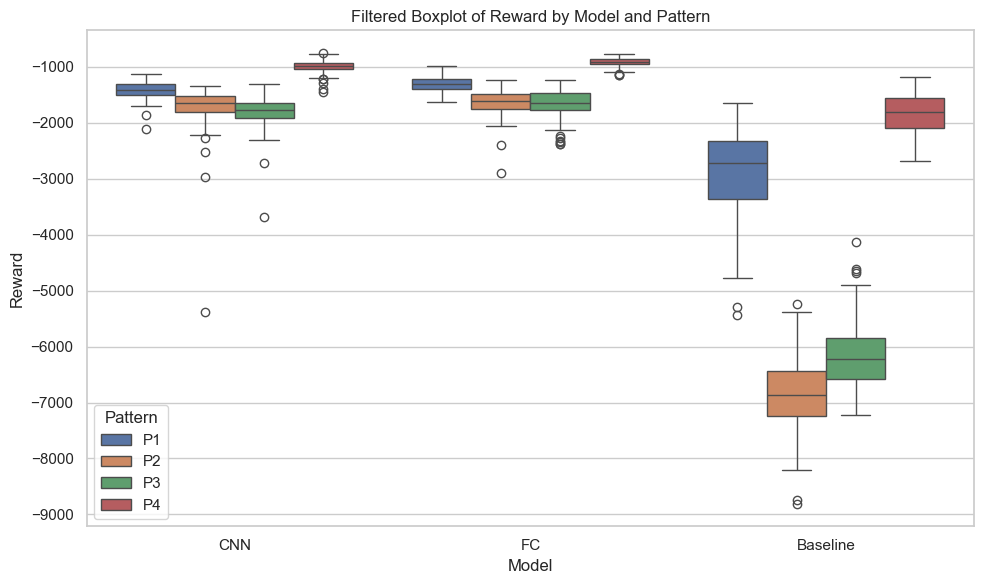

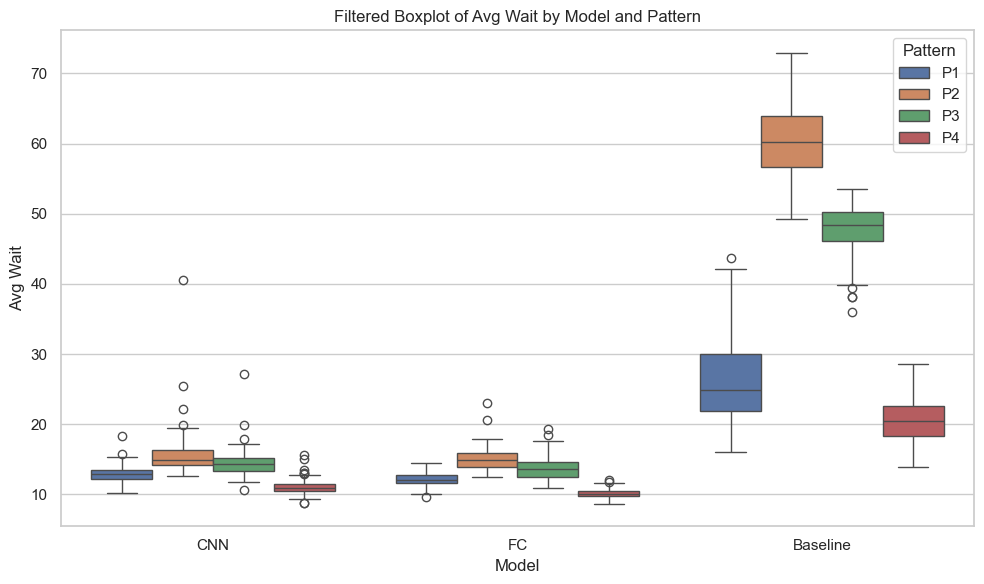

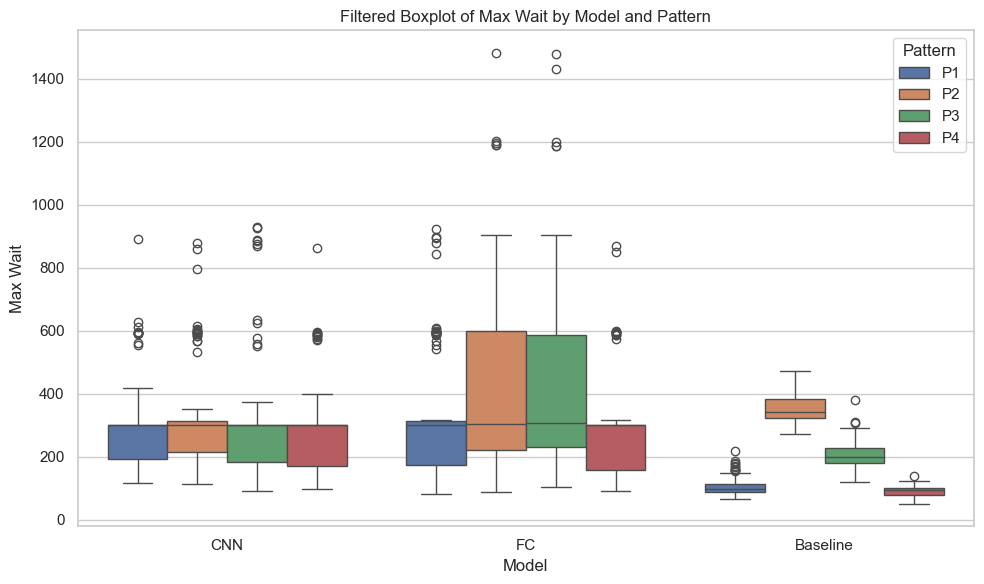

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


all_results = pd.concat([cnn_results_compiled, fc_results_compiled, baseline_results_compiled], ignore_index=True)

thresholds = {
    "Reward": {"min": -20000, "max": 100000},
    "Avg Wait": {"min": 0, "max": 150},
    "Max Wait": {"min": 0, "max": 1500},
}

def plot_metric_boxplot_filtered(metric_name):
    min_val = thresholds[metric_name]["min"]
    max_val = thresholds[metric_name]["max"]

    filtered_df = all_results[
        (all_results["Metric"] == metric_name) &
        (all_results["Value"] >= min_val) &
        (all_results["Value"] <= max_val)
    ]

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=filtered_df,
        x="Model",
        y="Value",
        hue="Pattern"
    )
    plt.title(f"Filtered Boxplot of {metric_name} by Model and Pattern")
    plt.ylabel(metric_name)
    plt.xlabel("Model")
    plt.legend(title="Pattern")
    plt.tight_layout()
    plt.show()

# Plot each metric with filtering
plot_metric_boxplot_filtered("Reward")
plot_metric_boxplot_filtered("Avg Wait")
plot_metric_boxplot_filtered("Max Wait")


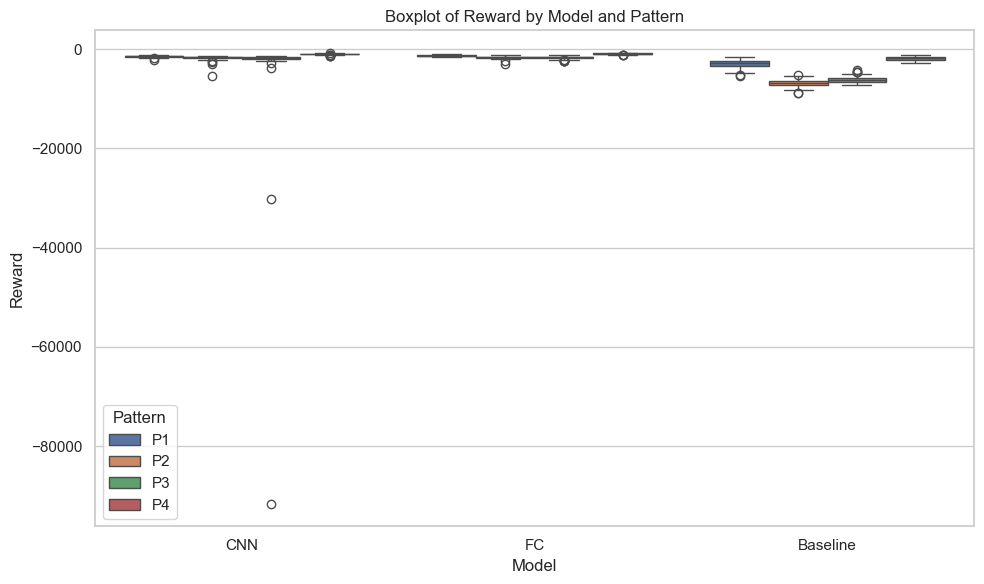

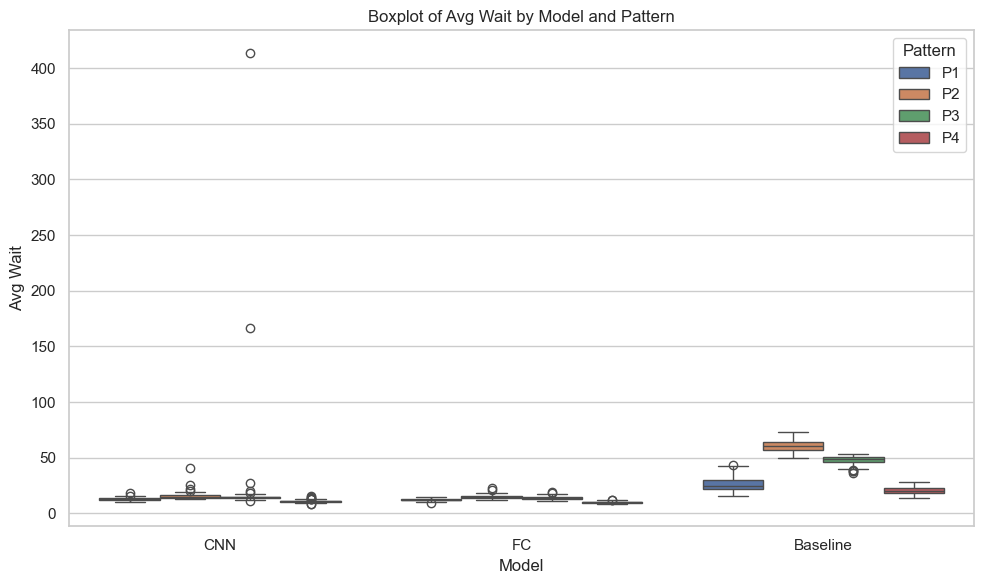

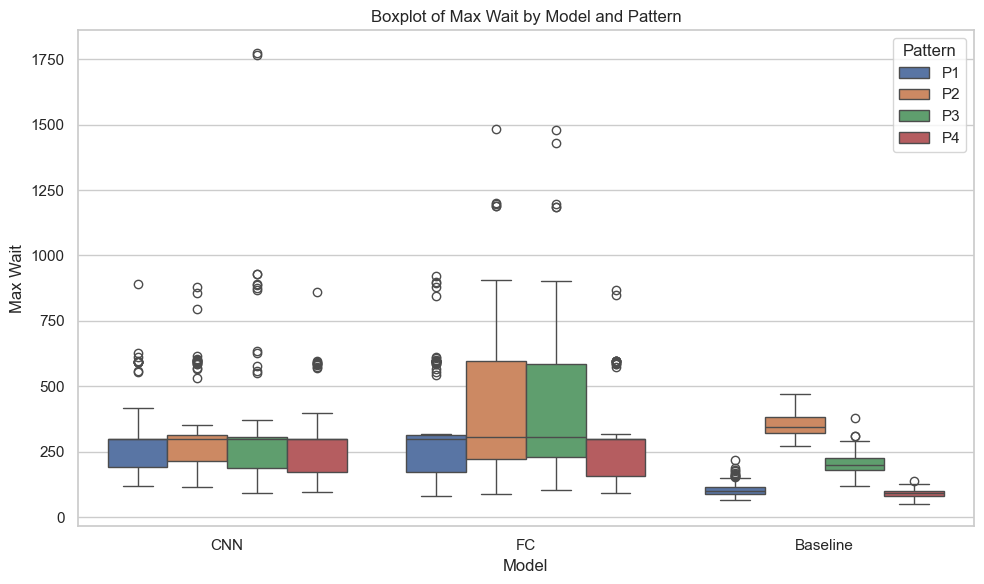

In [100]:
# Function to plot each metric
def plot_metric_boxplot(metric_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=all_results[all_results["Metric"] == metric_name],
        x="Model",
        y="Value",
        hue="Pattern"
    )
    plt.title(f"Boxplot of {metric_name} by Model and Pattern")
    plt.ylabel(metric_name)
    plt.xlabel("Model")
    plt.legend(title="Pattern")
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_metric_boxplot("Reward")
plot_metric_boxplot("Avg Wait")
plot_metric_boxplot("Max Wait")


# **Discussion**

Summary of results and analysis here - Michael pls

**Limitations**

### 🚧 1. CNN Model Instability
A key limitation of our project was the poor performance of the CNN model, which theoretically should perform better as it encodes more information relative to queue lane lengths — specifically, it is able to capture movement and location of cars that are not in queue yet. In our evaluations of the model, we observe extreme outliers in performance on the P3 traffic pattern from the CNN model. This, along with the unstable episode rewards during training, indicates that the CNN model had trouble approximating the Q function for the entire action state space.

### ⚖️ 2. Poor Max Waiting Time Performance Relative to Baseline
Previous work on this problem focused on the average values of queue length and waiting time. But by looking at the maximum waiting time, we observe that the Reinforcement Learning agents perform more poorly relative to baseline models. In order to maximise the reward, the agent likely chooses traffic lights that allow the most congested lanes to pass first. In scenarios where there are less congested lanes with only a few vehicles, these cars may be left waiting indefinitely, since prioritizing them does little to improve the total reward. This is more of an ethics problem - should we prioritise the collective (pause) or should we ensure fairness for all. 

<p align="center">
  <img src="image_1.png" alt="Image of lane with less congestion" />
</p>

### 🚦 3. Conflict between optimal queue reduction and road safety
We also have an ethical dilemma between optimal queue reduction and road safety. Currently, traffic light phases have a minimum length of 6 seconds (based on NSW traffic guidelines). We can give the RL agents more fine grained control over traffic lights by reducing the minimum phase length, but this may result in more dangerous road conditions since real life drivers may prefer more stable and predictable signal patterns. 





**Possible future work**

### 1. Improve CNN model
Future work could aim to improve the CNN’s ability to approximate the Q-function more accurately. This can be done by exploring different CNN architectures such as adding more layers, changing filter sizes and stride length. The memory size for experience replay can also be enlarged, allowing the network to see more data points and thus approximate more accurately.

### 2. Incorporation of Waiting Time into Reward 
The omission of waiting time considerations significantly limits the model’s applicability in real-world scenarios. Our RL agents tend to neglect less congested lanes, as servicing them yields minimal gains in the overall reward function. This behavior is undesirable in real-world applications as low-traffic lanes serve real users, and excessive delays can lead to driver frustration, non-compliance with signals, or even safety risks. Real traffic systems must ensure a minimum level of service for all lanes, regardless of volume. 

To handle this, we can incorporate maximum waiting time into the reward function. The choice of the constant $\alpha$, is subjective and dependent on how much maximum waiting time is valued.
$$
R = -(\text{total queue length} + \alpha \cdot \text{max waiting time})
$$

### 3. More control over traffic light duration
When our model selects an action, it currently extends the traffic light by a length of 6 seconds. This means that a green traffic light can only last for periods that are divisible by 6. This limitation stems from the design of our RL agent, and not from real-world traffic regulations. To overcome this, future studies may try building agents which are also capable of choosing how long a traffic light lasts for. This can be done by adding an additional regression head to our DQN, which will then be able to output both the Q values of each potential traffic light phase and also the length of the phase. The conflict between this and the minimum traffic light length duration of 6 seconds in NSW can be easily overcome by using $$ \min(\text{DQN output}, \text{NSW minimum green length}). $$

### 4. Expanding beyond a single intersection
While our project focused on a single intersection, real world traffic systems involve complex interactions between multiple intersections. Expanding the model to larger road networks would allow us to investigate coordination between traffic lights, assess network-wide efficiency, and test whether localized policies scale effectively. It would also enable exploration of strategies like synchronizing consecutive green lights to reduce stop-start driving and improve overall flow. Such a study would require significant amounts of data to replicate real world conditions, and also significant compute for simulation and training.

<p align="center">
  <img src="image_2.png" alt="Image of Sydney traffic network" />
</p>
